In [1]:
# !pip install tensorboard
# !pip install ipywidgets widgetsnbextension pandas-profiling
import os
import math
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, fbeta_score
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
import copy
import re
import matplotlib.pyplot as plt 

2021-09-29 20:08:10.017701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64:/usr/lib/x86_64-linux-gnu:/usr/local/lib64:/usr/local/cuda/lib64:/usr/lib64:/usr/lib/x86_64-linux-gnu:/usr/local/lib64:/usr/local/cuda/lib64:/usr/lib64:/usr/lib/x86_64-linux-gnu:/usr/local/lib64:/usr/local/cuda/lib64:
2021-09-29 20:08:10.017777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
!nvidia-smi

Wed Sep 29 20:08:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 35%   48C    P8    10W / 250W |      1MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:06:00.0 Off |                  N/A |
| 38%   53C    P8    13W / 250W |      1MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
torch.cuda.is_available()

True

In [4]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
train_df.head()

,id,title,abstract,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0


In [6]:
#border = len(train_df[train_df["judgement"] == 1]) / len(train_df["judgement"])
border = 0.02
print(border)

0.02


In [7]:
len(train_df)

27145

In [8]:
train_df.isnull().sum()

id              0
title           0
abstract     4390
judgement       0
dtype: int64

In [9]:
def get_texts(df):
    titles_and_abstracts = df['title_and_abstract'].values.tolist()
    return titles_and_abstracts

def get_labels(df):
    labels = df.iloc[:, 3].values
    return labels

def clean_text(text):

    if type(text) == float:
        text = ''
    #print(text)
    
    #text = text.lower()
    
    text = text.split()
    text = [x.strip() for x in text]
    text = [x.replace('\n', ' ').replace('\t', ' ') for x in text]
    text = ' '.join(text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    #text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    
    
    text = preprocess(text)
    
    #remove stopwords
    #stop = stopwords.words('english')
    #text = " ".join([word for word in text.split() if word not in (stop)])
    
    return text

def preprocess(sentence):
    sentence = replace_double_quotation(sentence)
    sentence = replace_garbled_text(sentence)
    return sentence

def replace_garbled_text(sentence):
    garbled_char_table = {
        'Â©': '©', '–': '-', '‐': '-',
        'ﾂ｣': '£', 'ﾂｩ': '©', 'ﾂｫ': '«', 'ﾂｮ': '®', 'ﾂｰ': '°', 'ﾂｱ': '±', 'ﾂｲ': '²', 'ﾂｳ': '³', 'ﾂｴ': '´', 'ﾂｵ': 'µ', 'ﾂｷ': '·', 'ﾂｸ': '¸', 'ﾂｹ': '¹', 'ﾂｼ': '¼', 'ﾂｽ': '½', 'ﾂｾ': '¾', 'ﾂｿ': '¿', 'ﾂ': '',
        'ﾃｷ': '÷', 'ﾃｸ': 'ø', 'ﾃ': 'a', 'ﾃ｡': 'a', 'ﾃ｢': 'a', 'ﾃ｣': 'a', 'ﾃ､': 'a', 'ﾃ･': 'a', 'ﾃｦ': 'ae', 'ﾃｧ': 'c', 'ﾃｨ': 'e', 'ﾃｩ': 'e', 'ﾃｪ': 'e', 'ﾃｫ': 'e',
        'ﾃｬ': 'i', 'ﾃｭ': 'i', 'ﾃｮ': 'i', 'ﾃｯ': 'i', 'ﾃｱ': 'n', 'ﾃｲ': 'o', 'ﾃｳ': 'o', 'ﾃｴ': 'o', 'ﾃｵ': 'o', 'ﾃｶ': 'o', 'ﾃｹ': 'u', 'ﾃｺ': 'u', 'ﾃｻ': 'u', 'ﾃｼ': 'u', 'ﾃｽ': 'y', 'ﾃｿ': 'y', 'ﾃ': '×', 
        'ﾎｱ': 'α', 'ﾎｲ': 'β', 'ﾎｳ': 'γ', 'ﾎｴ': 'δ', 'ﾎｵ': 'ε', 'ﾎｶ': 'ζ', 'ﾎｷ': 'η', 'ﾎｸ': 'θ', 'ﾎｹ': 'ι', 'ﾎｺ': 'κ', 'ﾎｻ': 'λ', 'ﾎｼ': 'μ', 'ﾎｽ': 'ν', 'ﾎｾ': 'ξ', 'ﾎｿ': 'ο', 'ﾎ': '',
        'ﾏ': ' ',
        '竕､': '≤', '竕･': '≥', '竕ｦ': '≦', '竕ｧ': '≧',
        '窶｢': '•', '窶ｦ': '…', '窶ｲ': '′', '窶ｳ': '″', '窶ｴ': '‴', '窶': ' ',
        '竅ｰ': '⁰', '竅ｴ': '⁴', '竅ｵ': '⁵', '竅ｶ': '⁶', '竅ｷ': '⁷', '竅ｸ': '⁸', '竅ｹ': '⁹', '竅ｺ': '⁺', '竅ｻ': '⁻', '竅ｼ': '⁼', 
        '竏･': '∥', '竏ｪ': '∪', '竏ｫ': '∫', '竏ｶ': '∶', '竏ｼ': '∼', '竏': '', 
        'ﾂ\uf8f0': ' '
    }
    for garbled_char, valid_char in garbled_char_table.items():
        sentence = sentence.replace(garbled_char, valid_char)
    sentence = re.sub('[ぁ-んァ-ンｦ-ﾟ一-龥]', '', sentence)
    return sentence.translate(garbled_char_table)

def replace_double_quotation(sentence):
    return sentence.replace('"', "'")  

def clean_data(train_df):
    train_df.loc[train_df['abstract'].isnull(), 'abstract'] = train_df['title']
    train_df['abstract'] = train_df['abstract'].apply(clean_text)
    train_df['title'] = train_df['title'].apply(clean_text)
    return train_df

def concat(train_df):
    train_df['title_and_abstract'] = train_df['title'] + train_df['abstract']
    return train_df

train_df.loc[[2488,7708],['judgement']] = 0
train_df = clean_data(train_df)
test_df= clean_data(test_df)
train_df = concat(train_df)
test_df = concat(test_df)
train_df.head()

,id,title,abstract,judgement,title_and_abstract
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,One-year age changes in MRI brain volumes in o...
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,Supportive CSF biomarker evidence to enhance t...
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,Occurrence of basal ganglia germ cell tumors w...
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,New developments in diagnosis and therapy of C...
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,Prolonged shedding of SARS-CoV-2 in an elderly...,0,Prolonged shedding of SARS-CoV-2 in an elderly...


In [10]:
print(train_df.loc[0,'title_and_abstract'])

One-year age changes in MRI brain volumes in older adults . Longitudinal studies indicate that declines in cognition and memory accelerate after age 70 years .  The neuroanatomic and neurophysiologic underpinnings of cognitive change are unclear as there is little information on longitudinal brain changes .  We are conducting a longitudinal neuroimaging study of nondemented older participants in the Baltimore Longitudinal Study of Aging .  This report focuses on age and sex differences in brain structure measured by magnetic resonance imaging during the first two annual evaluations .  Cross-sectional results from 116 participants aged 59-85 years reveal significantly larger ventricular volumes and smaller gray and white matter volumes in older compared with younger participants and in men compared with women .  Regional brain volumes show that the effects of age and sex are not uniform across brain regions .  Age differences are greatest for the parietal region .  Sex differences tend 

In [11]:
train_df.isnull().sum()
test_df.isnull().sum()

id                    0
title                 0
abstract              0
title_and_abstract    0
dtype: int64

In [12]:
# ax = sns.countplot(x='judgement', data=train_df)?

In [13]:
title = train_df['title'].tolist()
# y = [len(t.split()) for t in title]
# x = range(0, len(y))
# plt.bar(x, y)

In [14]:
abstract = train_df['abstract'].tolist()
# y = [len(a.split()) for a in abstract]
# x = range(0, len(y))
# plt.bar(x, y)

In [15]:
class Config:
    def __init__(self):
        super(Config, self).__init__()
        
        self.SEED = 42
        self.MODEL_PATH = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract'
        self.NUM_LABELS = 1
        
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 512
        self.BATCH_SIZE = 32
        self.N_SPLIT = 5
        
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 2e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 1
        self.EPOCHS = 2
        
config = Config()

In [16]:
def seed_init(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed = config.SEED
seed_init(seed)

In [17]:
class TransformerDataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset, self).__init__()

        df = df.iloc[indices]
        self.titles_and_abstracts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.max_length = config.MAX_LENGTH
        self.tokenizer = config.TOKENIZER

    def __len__(self):
        return len(self.titles_and_abstracts)
    
    def __getitem__(self, index):
        tokenized_titles_and_abstracts = self.tokenizer.encode_plus(
            self.titles_and_abstracts[index], 
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        input_ids_titles_and_abstracts = tokenized_titles_and_abstracts['input_ids'].squeeze()
        attention_mask_titles_and_abstracts = tokenized_titles_and_abstracts['attention_mask'].squeeze()
        

        if self.set_type != 'test':
            return {
                'titles_and_abstracts': {
                    'input_ids': input_ids_titles_and_abstracts.long(),
                    'attention_mask': attention_mask_titles_and_abstracts.long(),
                },
                'labels': torch.Tensor([self.labels[index]]).float(),
            }

        return {
            'titles_and_abstracts': {
                'input_ids': input_ids_titles_abstracts.long(),
                'attention_mask': attention_mask_titles_and_abstracts.long(),
            }
        }

In [18]:
class PubMedBert(nn.Module):
    def __init__(self):
        super(PubMedBert, self).__init__()
        self.model = AutoModel.from_pretrained(config.MODEL_PATH)
        self.dropout = nn.Dropout(0.25)
        self.avgpool = nn.AvgPool1d(2, 2)
        self.linear = nn.Linear(768, config.NUM_LABELS)
    
    def forward(self, input_ids_titles_and_abstracts, attention_mask_titles_and_abstracts=None):
        output = self.model(input_ids=input_ids_titles_and_abstracts, attention_mask=attention_mask_titles_and_abstracts)
        features = output.pooler_output
        features = features.unsqueeze(1)
        features_pooled = self.avgpool(features)
        features_pooled = features_pooled.squeeze(1)

        x = self.dropout(features)
        x = self.linear(x)
        
        return x

In [19]:
def val(model, val_dataloader, criterion, epoch):
    val_loss = 0
    true, pred, output = [], [], []
    
    model.eval()
    
    for step, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        b_input_ids = batch['titles_and_abstracts']['input_ids'].to(device)
        b_attention_mask = batch['titles_and_abstracts']['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        with torch.no_grad():
            logits = model(b_input_ids, b_attention_mask)
            logits = logits.view(-1, 1)
            loss = criterion(logits, b_labels)
            val_loss += loss.item()
            
            logits = torch.sigmoid(logits)
            logits = logits.to('cpu').detach().numpy().copy()
            output.extend(logits.tolist())
            logits = np.where(logits < border, 0, 1)
            labels = b_labels.to('cpu').detach().numpy().copy()
            
            pred.extend(logits)
            true.extend(labels)
            
    output0, output1 = [], []
    for p, o in zip(true, output):
        if p == 0:
            output0.append(o[0])
        else:
            output1.append(o[0])
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.hist(output0, bins=100, color='red', alpha=0.5)
    ax1.set_xlabel('output')
    ax1.set_ylabel('sum')
    ax1.set_title('val_0')
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.hist(output1, bins=100, color='blue', alpha=0.5)
    ax2.set_xlabel('output')
    ax2.set_ylabel('sum')
    ax2.set_title('val_1')
    
    fig.savefig('graph/val'+str(epoch)+'.png')
        
    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true, pred))
    
    val_fbeta_score = fbeta_score(true, pred, beta=7.0)
    print('Val fbeta score:', val_fbeta_score)
    return val_fbeta_score

In [20]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp%100)
    validate_at_steps = [temp * x for x in range(1, nv+1)]
    
    train_loss = 0
    true, pred, output = [], [], []
    for step, batch in tqdm(enumerate(train_dataloader), desc='Epoch ' + str(epoch), total=len(train_dataloader)):
        
        model.train()
        b_input_ids = batch['titles_and_abstracts']['input_ids'].to(device)
        b_attention_mask = batch['titles_and_abstracts']['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(b_input_ids, b_attention_mask)
        logits = logits.view(-1, 1)
#         print("logits=",logits)
        loss = criterion(logits, b_labels)
        train_loss += loss.item()
#         print(train_loss)
        
        logits = torch.sigmoid(logits)
        logits = logits.to('cpu').detach().numpy().copy()
        output.extend(logits.tolist())
        logits = np.where(logits < border, 0, 1)
        labels = b_labels.to('cpu').detach().numpy().copy()
            
        pred.extend(logits)
        true.extend(labels)
            
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        
        #if step in validate_at_steps:
        #    print(f'-- Step: {step}')
        #    _ = val(model, val_dataloader, criterion)
        
    output0, output1 = [], []
    for p, o in zip(true, output):
        if p == 0:
            output0.append(o[0])
        else:
            output1.append(o[0])
            
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.hist(output0, bins=100, color='red', alpha=0.5)
    ax1.set_xlabel('output')
    ax1.set_ylabel('sum')
    ax1.set_title('train_0')

    ax2 = fig.add_subplot(1,2,2)
    ax2.hist(output1, bins=100, color='blue', alpha=0.5)
    ax2.set_xlabel('output')
    ax2.set_ylabel('sum')
    ax2.set_title('train_1')
    
    fig.savefig('graph/train'+str(epoch)+'.png')
    
    avg_train_loss = train_loss / len(train_dataloader)
    accuracy = accuracy_score(true, pred)
    train_fbeta_score = fbeta_score(true, pred, beta=7.0)
    print('Training loss:', avg_train_loss)
    print('Training accuracy:', accuracy_score)
    print('Train fbeta score:', train_fbeta_score)
    return avg_train_loss, accuracy

In [21]:
def run(train_dataloader, val_dataloader, writer):
    
    !jupyter nbextension enable --py --sys-prefix widgetsnbextension
    torch.cuda.empty_cache()
    model = PubMedBert()
    model=nn.DataParallel(model)
    model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.001,
            },
            {
                "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)
    
    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
    
    max_val_fbeta_score = float('-inf')
    for epoch in range(config.EPOCHS):
        avg_train_loss, accuracy = train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_fbeta_score = val(model, val_dataloader, criterion, epoch)
        
        writer.add_scalar('train_loss', avg_train_loss, epoch+1)
        writer.add_scalar('accuracy', accuracy, epoch+1)
        writer.add_scalar('val_fbeta_score', val_fbeta_score, epoch+1)
        
        if config.SAVE_BEST_ONLY:
            if val_fbeta_score > max_val_fbeta_score:
                max_val_fbeta_score = val_fbeta_score
                best_model = copy.deepcopy(model)
                
    return best_model, max_val_fbeta_score

In [22]:
def cross_val():
    Fold = StratifiedKFold(n_splits=config.N_SPLIT, shuffle=True, random_state=seed)
    max_val_fbeta_score = float('-inf')
    
    for n, (train_indices, val_indices) in enumerate(Fold.split(train_df, train_df['judgement'])):
        print(f'========= fold: {n} training =========')
        
        log_dir = 'logs/fold'+str(n)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        
        writer = SummaryWriter(log_dir=log_dir)

        train_data = TransformerDataset(train_df, train_indices)
        val_data = TransformerDataset(train_df, val_indices)
        
        train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
        val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)
                
        fold_best_model, fold_best_val_fbeta_score = run(train_dataloader, val_dataloader, writer)
        
        if config.SAVE_BEST_ONLY:
            if fold_best_val_fbeta_score > max_val_fbeta_score:
                best_model = fold_best_model
                max_val_fbeta_score = fold_best_val_fbeta_score
                
                model_name = 'pubmedbert_input_best_model'
                torch.save(best_model.state_dict(), model_name+'.pt')
        
        writer.close()
                
    return best_model, max_val_fbeta_score

In [23]:
device = config.DEVICE
device

device(type='cuda')

========= fold: 0 training =========
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel

Epoch 0:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.06326788596981048
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.7586206896551724


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.038942116244887824
Val accuracy: 0.9441886166881562
Val fbeta score: 0.9395362933777845


Epoch 1:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.025935051358539463
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.9447422203370224


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.03530308147755397
Val accuracy: 0.9609504512801621
Val fbeta score: 0.9378843788437885
========= fold: 1 training =========
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel

Epoch 0:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.0620666417646097
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.7884568524384726


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.046687725041171205
Val accuracy: 0.9532142199300055
Val fbeta score: 0.8507050889025138


Epoch 1:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.028098831580751556
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.9413259413259415


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.04066506638602518
Val accuracy: 0.9642659790016578
Val fbeta score: 0.9107749305341155
========= fold: 2 training =========
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel

Epoch 0:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.06459572570829135
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.7528493255724792


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.03758328821482685
Val accuracy: 0.9460305765334316
Val fbeta score: 0.8897338403041825


Epoch 1:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.029865979658222356
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.9310808216548282


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.03155326468644061
Val accuracy: 0.9546877878062259
Val fbeta score: 0.9182736455463727
========= fold: 3 training =========
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel

Epoch 0:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.061393640483132894
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.7734998265695454


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.03754061575198327
Val accuracy: 0.9276109780806778
Val fbeta score: 0.9196949304620906


Epoch 1:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.025973869189061086
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.93827065351418


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.03631862208849805
Val accuracy: 0.9640817830171302
Val fbeta score: 0.9106343571538817
========= fold: 4 training =========
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel

Epoch 0:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.06041605400664948
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.7908550904821108


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.0446399338899509
Val accuracy: 0.9325842696629213
Val fbeta score: 0.8799638989169675


Epoch 1:   0%|          | 0/679 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.02372257720803518
Training accuracy: <function accuracy_score at 0x7f2957353c10>
Train fbeta score: 0.9538735391997524


  0%|          | 0/170 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Val loss: 0.04197909355930546
Val accuracy: 0.9690550745993738
Val fbeta score: 0.8695652173913041


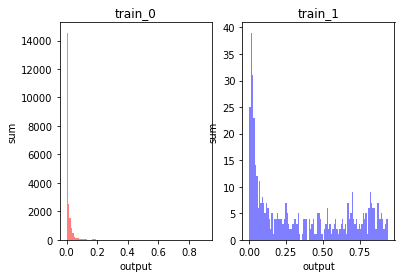

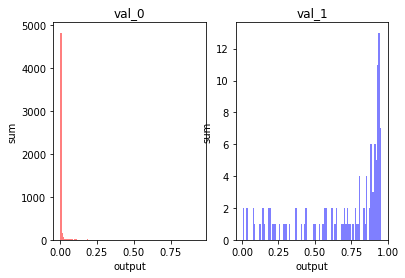

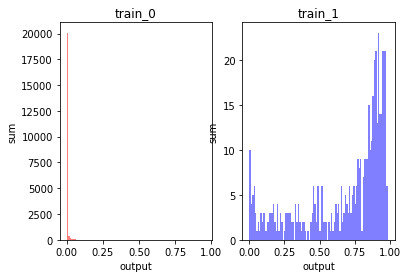

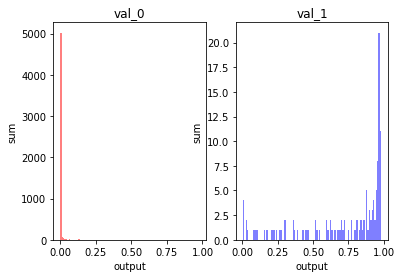

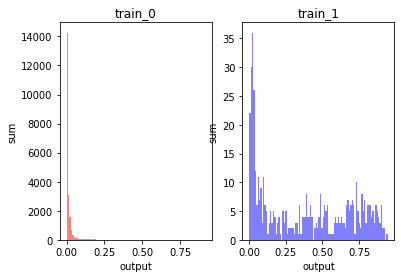

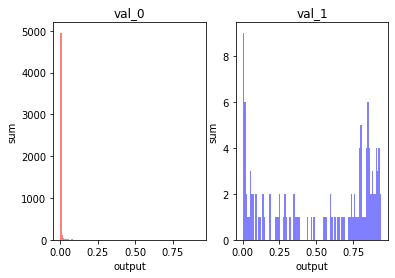

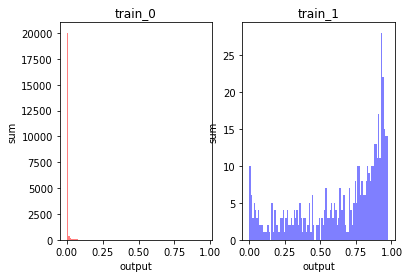

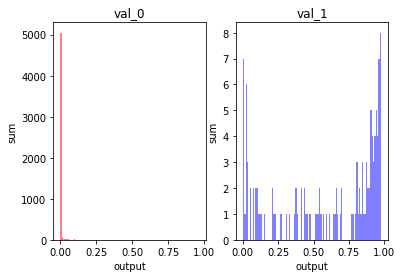

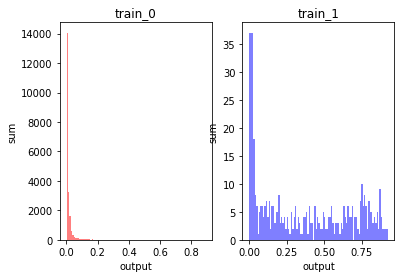

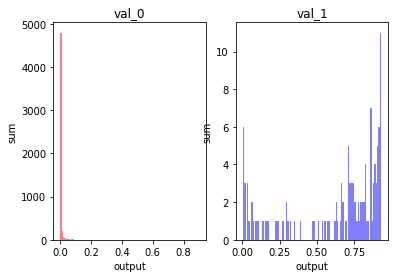

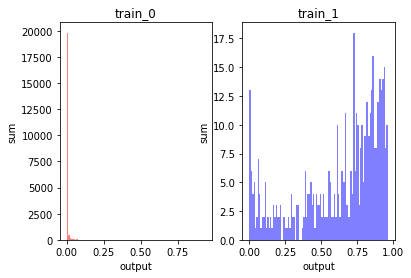

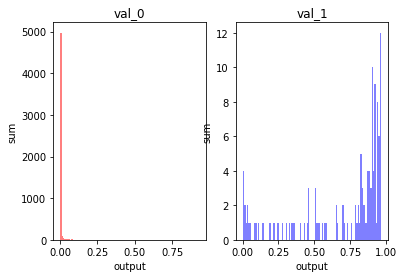

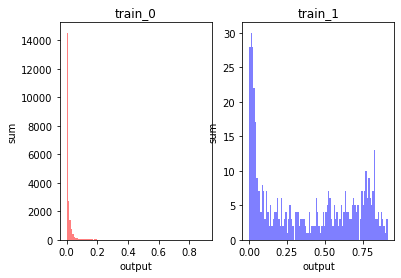

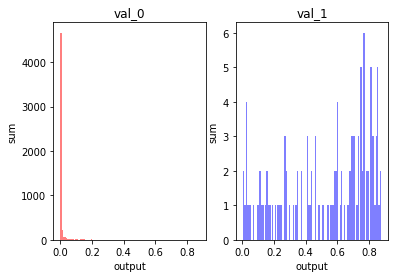

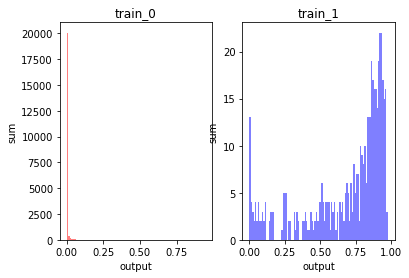

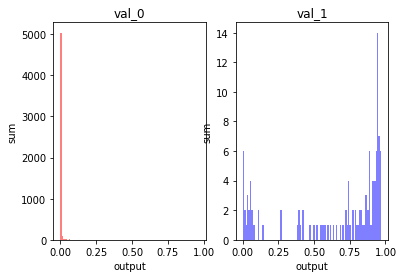

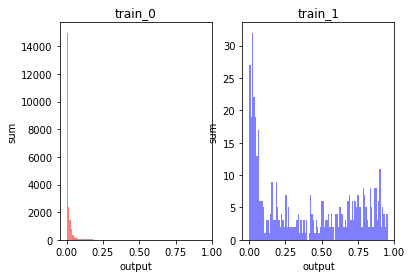

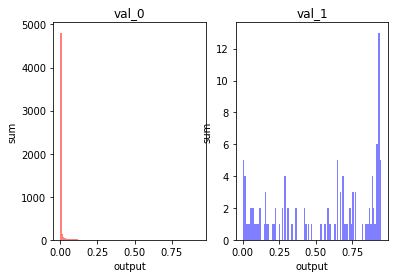

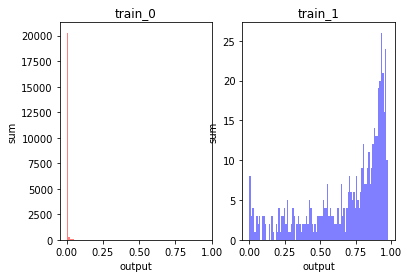

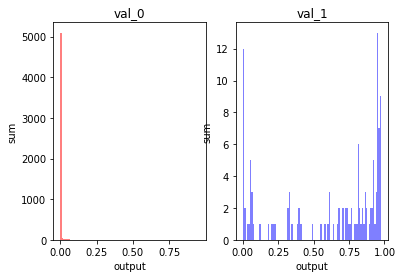

In [24]:
best_model, best_val_fbeta_score = cross_val()
#best_model = PubMedBert()
#best_model=nn.DataParallel(best_model)
#best_model.to(device)
#best_model.load_state_dict(torch.load('pubmedbert_input_best_model.pt'))

In [25]:
print(best_val_fbeta_score)

0.9395362933777845


In [26]:
dataset_size = len(test_df)
test_indices = list(range(dataset_size))
test_data = TransformerDataset(test_df, test_indices, set_type='test')
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)


def predict(model):
    val_loss = 0
    test_pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
#         batch = batch[0]
        b_input_ids = batch['titles_and_abstracts']['input_ids'].to(device)
        b_attention_mask = batch['titles_and_abstracts']['attention_mask'].to(device)
        
        with torch.no_grad():
            logits = model(b_input_ids, b_attention_mask)
            logits = logits.view(-1, 1)
            logits = torch.sigmoid(logits)
            logits = np.where(logits.to('cpu').detach().numpy().copy() < border, 0, 1)
            test_pred.extend(logits)
    
    test_pred = np.array(test_pred)
    return test_pred

test_pred = predict(best_model)

  0%|          | 0/1277 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


NameError: name 'input_ids_titles_abstracts' is not defined

In [ ]:
def submit():
    sample_submission = pd.read_csv('data/sample_submit.csv', names=('id', 'judgement'))
    ids = sample_submission['id'].values.reshape(-1,1)
    
    merged = np.concatenate((ids, test_pred), axis=1)
    submission = pd.DataFrame(merged, columns=sample_submission.columns).astype(int)
    return submission

submission = submit()

In [ ]:
submission.to_csv('output/outputs.csv', index=False, header=False)

In [ ]:
#validation accuracyをtensorboardで管理
#k_foldのscoreの平均値を出す
#f1からbetaスコアに変える